# Multiple S1 peaks in Kr MC

**In this notebook, it is shown how, in some cases, a tiny peak closely before to the S2 peak is misidentified as an S1 peak. It is also shown a method for avoiding such error. A preliminary study shows this happens about in about 4% of the events**

In [1]:
from __future__ import print_function
import tables as tb
import numpy as np
import time
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.fitFunctions as fit
import Core.tblFunctions as tbl
import Database.loadDB as DB
import Sierpe.FEE as FE
from Core.Bridges import Signal, Peak, PMap

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2
print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 18/11/2016 at 12:14:42.


In [72]:
try:
    h5maps.close()
except:
    pass

In [45]:
h5maps = tb.open_file("/Users/Gonzalo/github/IC/data/MC/Kr_preprod_DST.h5")

In [46]:
print(h5maps)

/Users/Gonzalo/github/IC/data/MC/Kr_preprod_DST.h5 (File) ''
Last modif.: 'Fri Nov 18 11:31:46 2016'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(686,), zlib(4)) ''
/PMAPS (Group) ''
/PMAPS/PMaps (Table(12864,), shuffle, zlib(4)) 'Store for PMaps'
/PMAPS/PMapsBLR (Table(0,), shuffle, zlib(4)) 'Store for PMaps made with BLR'
/TWF (Group) ''
/TWF/PMT (Table(12266,), shuffle, zlib(4)) 'Store for PMTs TWF'
/TWF/SiPM (Table(80483,), shuffle, zlib(4)) 'Store for SiPM TWF'



In [47]:
pmaps_ = h5maps.root.PMAPS.PMaps

In [48]:
nevt = len(set(pmaps_.cols.event))
pmaps = np.array(map(lambda i: tbl.read_pmap(pmaps_, i), range(nevt)), dtype=object)

## Histogram of the number of S1 peaks per event

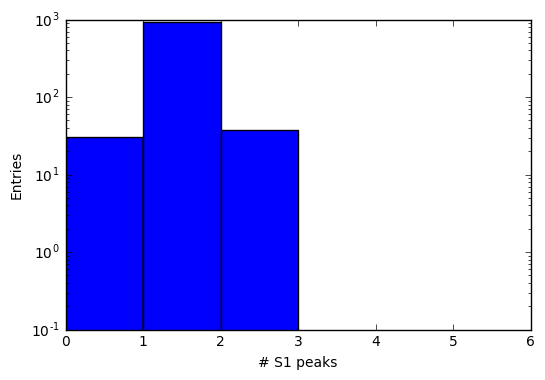

In [49]:
h = plt.hist([len(pmap.get_of_type("S1")) for pmap in pmaps],6,range=(0,6))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

## A plot of one event with double S1

(0, 10)

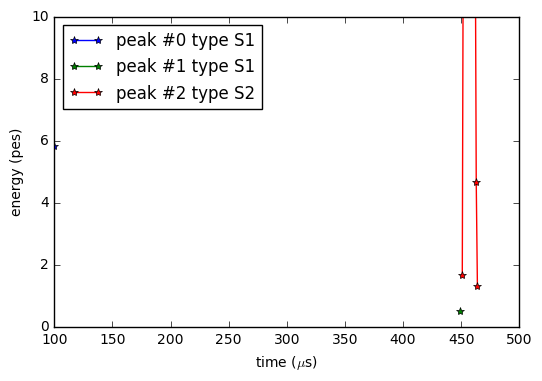

In [50]:
mpl.plot_pmap(filter(lambda p: len(p.get_of_type("S1"))==2, pmaps)[0])
plt.ylim((0,10))

### Most of the features of this kind of events are the same as of the true S1s:
1. Width
2. Time over threshold
3. Before S1

## But their cathode integral is different

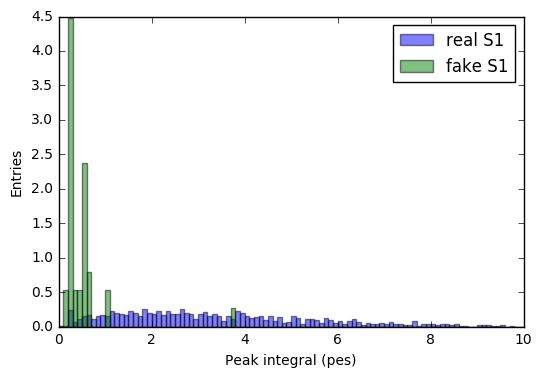

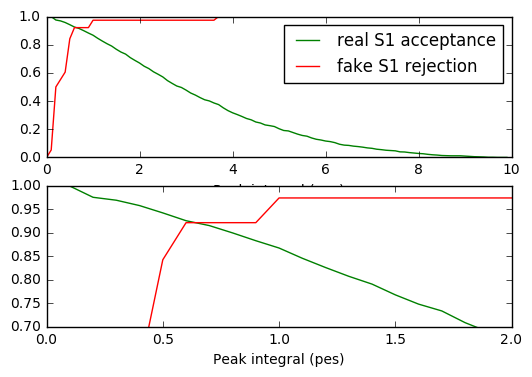

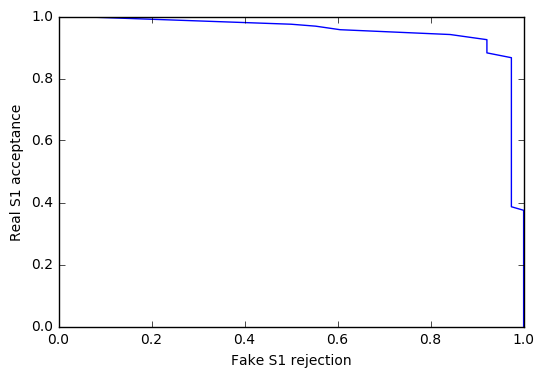

In [60]:
data = [map(lambda x: x.cathode_integral, pmap.get_of_type("S1")) for pmap in pmaps]
real = np.array([i[0] for i in data if len(i)>0])
fake = np.array([i[1] for i in data if len(i)>1])
hreal = plt.hist(np.array(real), 100, range=(0,10), alpha=0.5, label="real S1", normed=True)
hfake = plt.hist(np.array(fake), 100, range=(0,10), alpha=0.5, label="fake S1", normed=True)
plt.xlabel("Peak integral (pes)")
plt.ylabel("Entries")
plt.legend()

cumreal = hreal[0].cumsum(); cumreal /= cumreal[-1]
cumfake = hfake[0].cumsum(); cumfake /= cumfake[-1]
x = hreal[1][:-1]
plt.figure()
plt.subplot(2,1,1)
plt.plot(x, 1 - cumreal, "g", label="real S1 acceptance")
plt.plot(x, cumfake, "r", label="fake S1 rejection")
plt.xlabel("Peak integral (pes)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x, 1 - cumreal, "g", label="real S1 acceptance")
plt.plot(x, cumfake, "r", label="fake S1 rejection")
plt.xlabel("Peak integral (pes)")
plt.xlim((0,2))
plt.ylim((0.7,1))

plt.figure()
plt.plot(cumfake, 1-cumreal)

plt.xlabel("Fake S1 rejection")
plt.ylabel("Real S1 acceptance")


**A cut of ~0.6 pes in the peak integral can remove this cuchufleta. Lets check:**

In [66]:
def classify_peaks(pmap):
    foundS1 = False
    foundS2 = False
    s1min = .6
    s2min = 0.
    for peak in pmap:
        peak.signal = Signal.UNKNOWN
        if (len(peak) > 3 and peak.tothrs.sum() > 100 and
            peak.peakmax[1] > s2min):
            peak.signal = Signal.S2
            foundS2 = True
        elif len(peak) == 1 and peak.tothrs.sum() < 20 and not foundS2:
            if not foundS1 or peak.cathode_integral > s1min:
                peak.signal = Signal.S1
                foundS1 = True

In [67]:
nones = map(classify_peaks, pmaps)

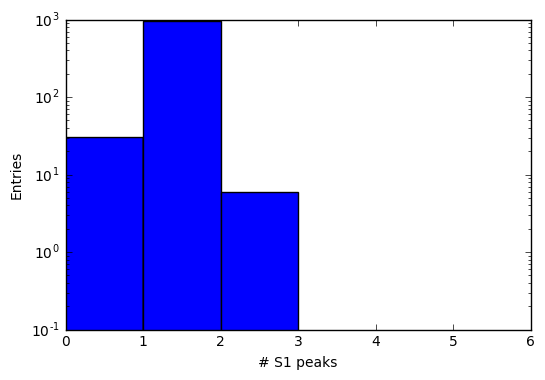

In [68]:
h = plt.hist([len(pmap.get_of_type("S1")) for pmap in pmaps],6,range=(0,6))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

**About 3% of the events lack S1 now, but we have reduced the double S1 scenario by 85%**